# Data Base

![PyData Berlin](resources/PyDataLogo.png) 

# Important Packages

![Numpy](resources/numpy.png) 

![Pandas](resources/pandas.png) 

![Matplotlib](resources/matplotlib.jpeg) 

![Seaborn](resources/seaborn.svg) 

![SciPy](resources/scipy.png) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib.mlab as mlab
import seaborn as sb
sb.set(style="white", palette="muted")
sb.set_context("talk")

%matplotlib inline

## Experiment: Static IMU and GNSS measurements

### Sensor measurements always include uncertainty

Sensor measurements of IMU and GNSS while positions are don't change. <br>
A sensor without any uncertainty would output constant values.


In [11]:
df = pd.read_csv('data/2014-06-27-001-Data.csv')
df.index = pd.to_datetime(df['millis'], unit='ms')

## Acceleration measurements

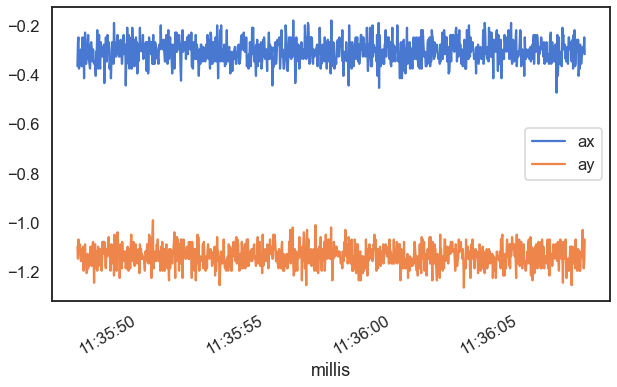

In [12]:
accelerations = df[['ax','ay']].dropna()
accelerations.plot(figsize=(10, 6));


### Reasons for offset
- Bad calibration of sensor
- Sensor placed at an angle --> gravity

## Distribution: Apply Gaussian

In [4]:
import scipy.stats as stats
from scipy.stats import norm
from ipywidgets import interact

In [14]:
@interact
def plot_sb_dist(column=accelerations.columns.tolist()):
    plt.figure(figsize=(10, 4))
    
    # Plot distribution
    sb.histplot(accelerations[column], kde=False, bins=15, label='# of Sensor Readings')
    plt.legend()
    


interactive(children=(Dropdown(description='column', options=('ax', 'ay'), value='ax'), Output()), _dom_classe…

### The Gaussian Normal distribution fits the sensor measurements!

In [15]:
@interact
def plot_sb_dist(column=accelerations.columns.tolist()):
    plt.figure(figsize=(10, 4))
    
    # Plot distribution
    sb.histplot(accelerations[column], kde=False, bins=15, label='# of Sensor Readings')
    plt.legend()
    
    #Plot Gaussian
    mu, std = norm.fit(accelerations[column])
    print("mean:          ", mu)
    print("variance:      ", std ** 2, "\n")
    print("std deviation: ", std)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std) * 20
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

interactive(children=(Dropdown(description='column', options=('ax', 'ay'), value='ax'), Output()), _dom_classe…

## GPS Measurement

GPS measurements are in latitude and longitude coordinate frame.

In [7]:
gps = pd.DataFrame()

Convert Lat Lon coordinates to UTM.

![UTM frame](resources/UTM.jpg) 

https://de.wikipedia.org/wiki/UTM-Koordinatensystem#/media/Datei:Utm-zones.jpg

In [16]:
from pyproj import Proj


utm_converter = Proj("+proj=utm +zone=33U, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
gps['UTMx'] = df.latitude
gps['UTMy'] = df.longitude

for i in range(len(df.longitude)):
    gps['UTMx'].array[i], gps['UTMy'].array[i] = utm_converter(df.longitude[i], df.latitude[i])

ModuleNotFoundError: No module named 'pyproj'

### From a perfect position sensor we would expect all measurements to be in one point.

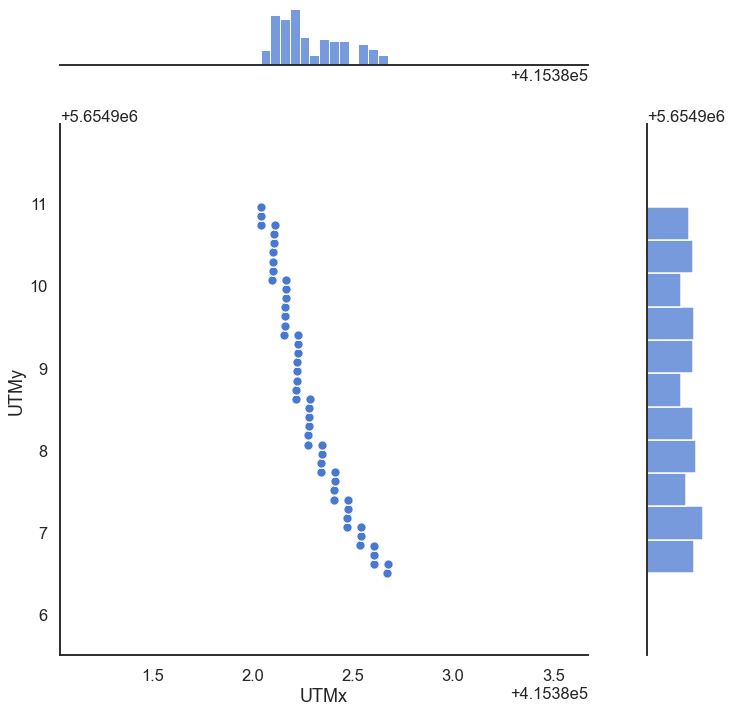

In [9]:
sb.jointplot(x=gps.UTMx, y=gps.UTMy, kind='scatter', \
             xlim=(gps.UTMx.min()-1, gps.UTMx.max()+1), \
             ylim=(gps.UTMy.min()-1, gps.UTMy.max()+1), \
             height=10, space=1)

### Uncertainty in $y$ is way bigger than in $x$.

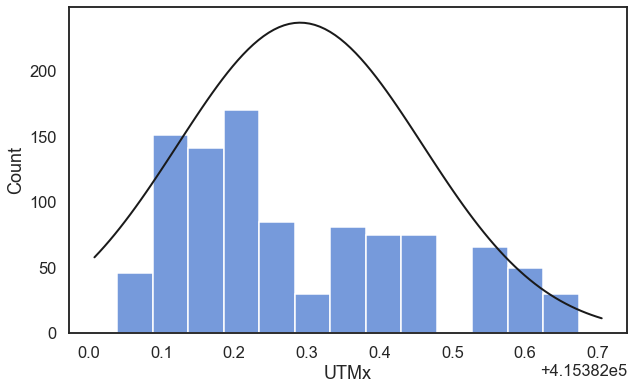

In [10]:
@interact
def plot_sb_dist(column=gps.columns.tolist()):
    plt.figure(figsize=(10, 6))
    
    # plot distribution
    sb.histplot(gps[column])
    
    # plot Gaussian
    mu, std = norm.fit(gps[column])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std) * 100
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

### Sensor measurements are not exact Gaussians. But it still gives us a nice estimate.

<br>
<br>
<br>
<br>
<br>

# Kalman Filter in 1 Dimension

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
from scipy import stats
import time
sb.set()  # Reset Style
sb.set_context("talk")

In [12]:
%matplotlib inline
fw = 10 # figure width

In [20]:
# Plot the Distributions in this range:
x = np.linspace(-50,100,1000)

## Initial State

Initial position is set to 0 if we don't have further information.
The initial variance can be set according to expected values.

In [23]:
mean0 = 0.0   # e.g. meters
var0  = 3.0

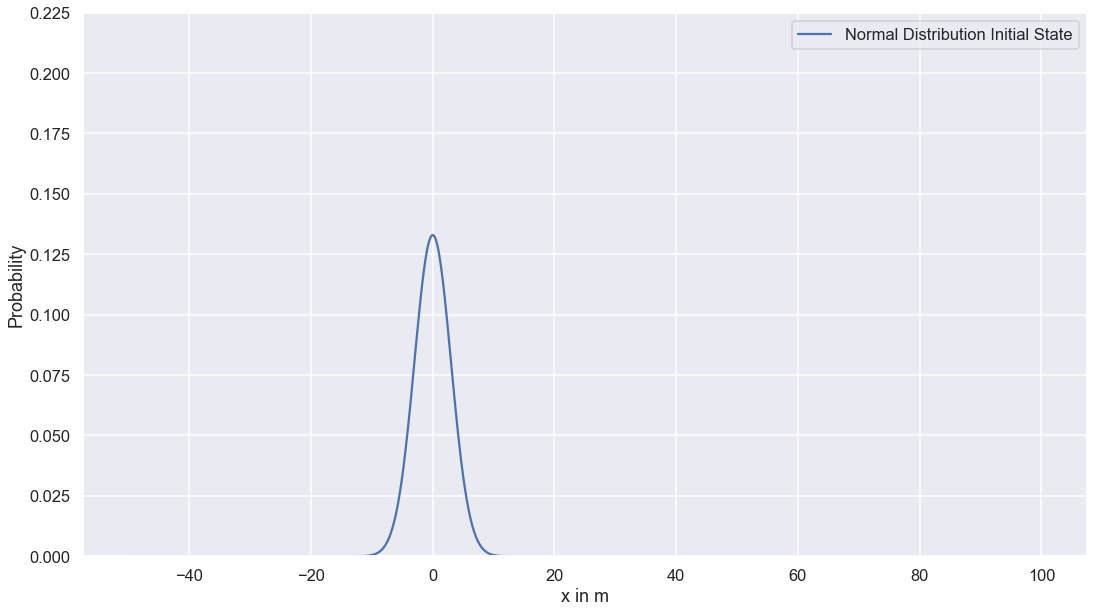

In [24]:
plt.figure(figsize=(18,10))
plt.plot(x, stats.norm.pdf(x, mean0, var0), label='Normal Distribution Initial State')
plt.ylim(0, 0.225);
plt.legend(loc='best');
plt.ylabel('Probability');
plt.xlabel('x in m');

## Motion Prediction

Use motion model (e.g. point mass model) to predict motion.
Motion is assumed as a Gaussian distribution.

In [25]:
meanMove = 25.0  # e.g. meters, calculated from velocity*dt, wheelspeed sensors etc.
varMove  = 5.0   # Estimated or determined with static measurements

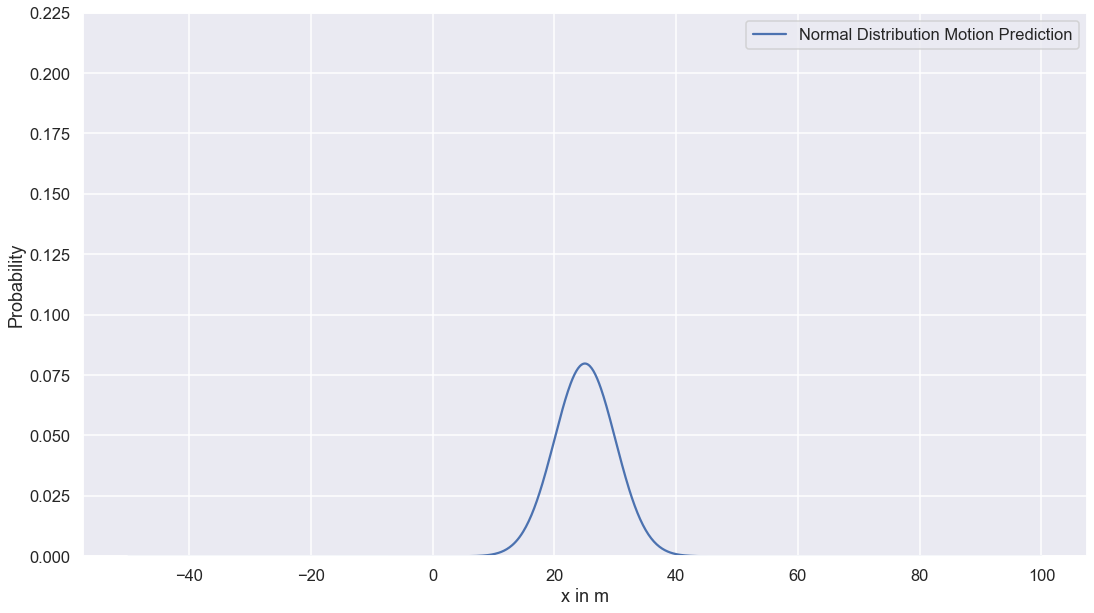

In [26]:
plt.figure(figsize=(18,10))
plt.plot(x, stats.norm.pdf(x, meanMove, varMove), label='Normal Distribution Motion Prediction')
plt.ylim(0, 0.225);
plt.legend(loc='best');
plt.ylabel('Probability');
plt.xlabel('x in m');

## Addition of motion prediction to prior position estimate

![Motion Prediction Slide](resources/MotionPrediction.png) 

In [27]:
def predict(var, mean, varMove, meanMove):
    new_mean= mean+ meanMove
    new_var = var + varMove
    return new_var, new_mean

In [28]:
new_var, new_mean = predict(var0, mean0, varMove, meanMove)

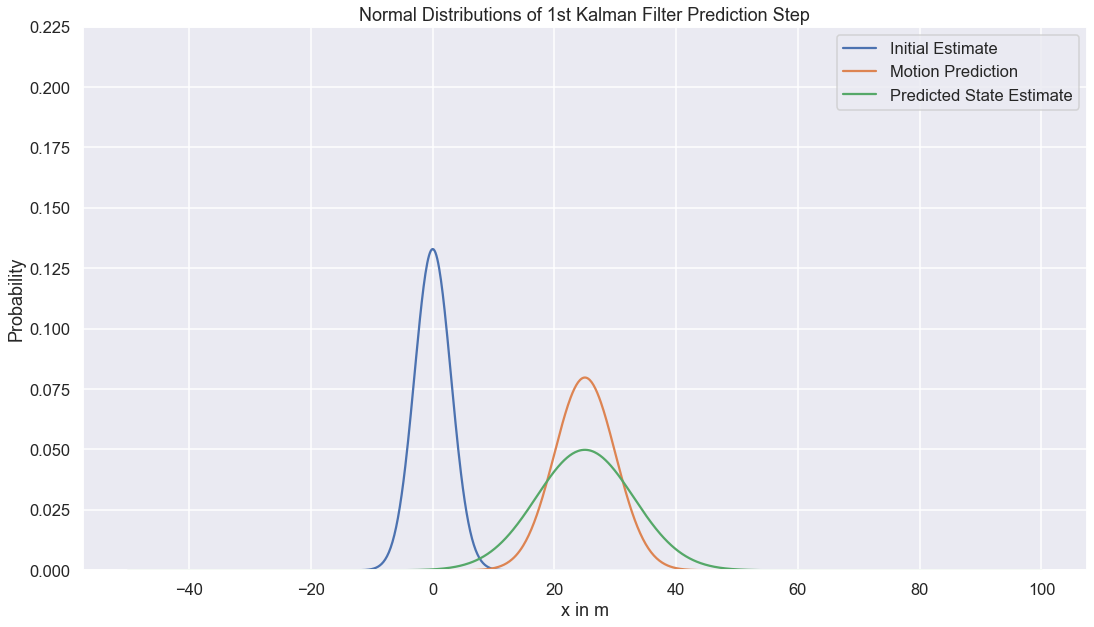

In [29]:
plt.figure(figsize=(18,10))
plt.plot(x, stats.norm.pdf(x, mean0, var0), label='Initial Estimate')
plt.plot(x, stats.norm.pdf(x, meanMove, varMove), label='Motion Prediction')
plt.plot(x, stats.norm.pdf(x, new_mean, new_var), label='Predicted State Estimate')
plt.ylim(0, 0.225);
plt.legend(loc='best');
plt.title('Normal Distributions of 1st Kalman Filter Prediction Step');
plt.ylabel('Probability');
plt.xlabel('x in m');

## The motion prediction increases the uncertainty!

<br>
<br>

# Measurement Update
## We assume a direct position measurement (GNSS)

### Sensor Defaults for Position Measurements

In [21]:
meanSensor = 27.0
varSensor  = 3.0

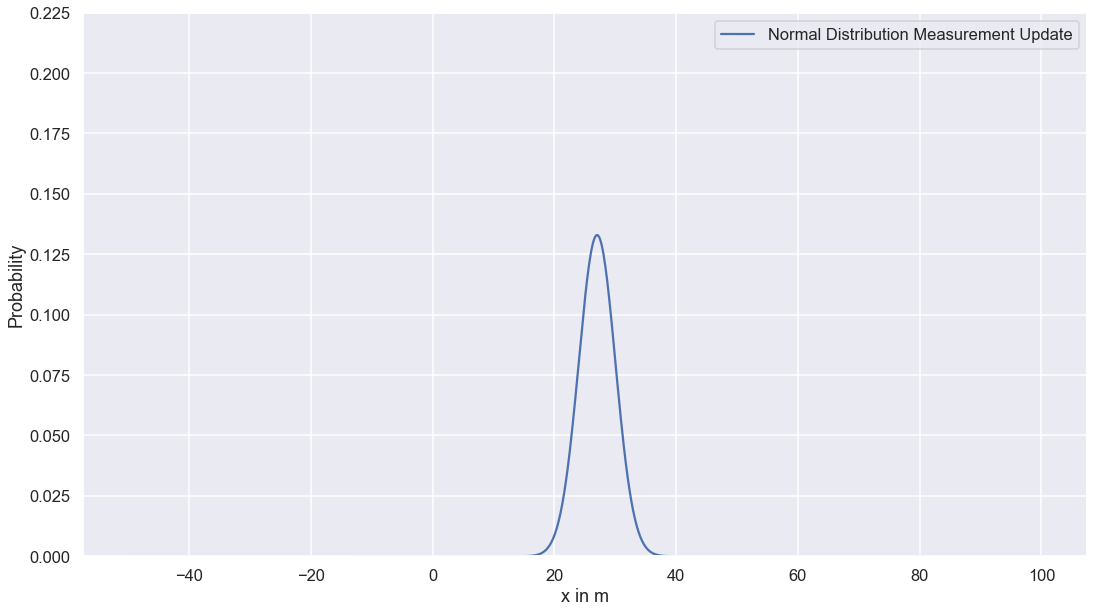

In [22]:
plt.figure(figsize=(18,10))
plt.plot(x, stats.norm.pdf(x, meanSensor, varSensor), label='Normal Distribution Measurement Update')
plt.legend(loc='best');
plt.ylim(0, 0.225);
plt.ylabel('Probability');
plt.xlabel('x in m');

## Combination of prior position estimate and new sensor measurement

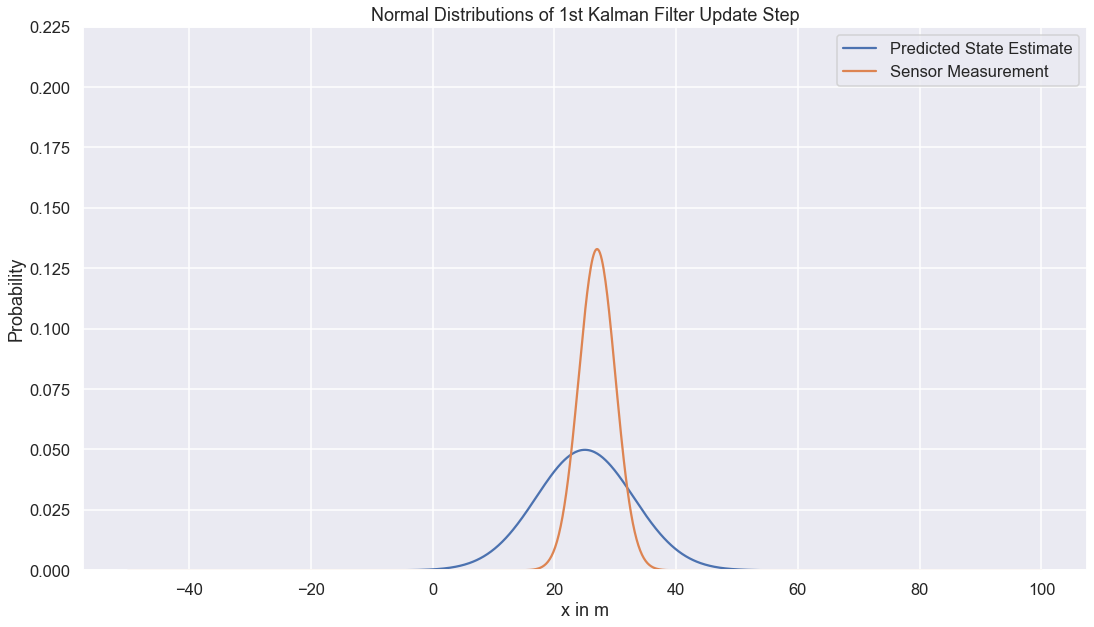

In [23]:
plt.figure(figsize=(18,10))
plt.plot(x, stats.norm.pdf(x, new_mean, new_var), label='Predicted State Estimate')
plt.plot(x, stats.norm.pdf(x, meanSensor, varSensor), label='Sensor Measurement')
plt.ylim(0, 0.225);
plt.legend(loc='best');
plt.title('Normal Distributions of 1st Kalman Filter Update Step');
plt.ylabel('Probability');
plt.xlabel('x in m');

![Measurement Update Slide](resources/MeasurementUpdate.png) 

In [24]:
def update(var, mean, varSensor, meanSensor):
    new_mean=(varSensor * mean + var * meanSensor) / (var + varSensor)
    new_var = 1 / (1 / var + 1 / varSensor)
    return new_var, new_mean

In [25]:
var, mean = update(new_var, new_mean, varSensor, meanSensor)

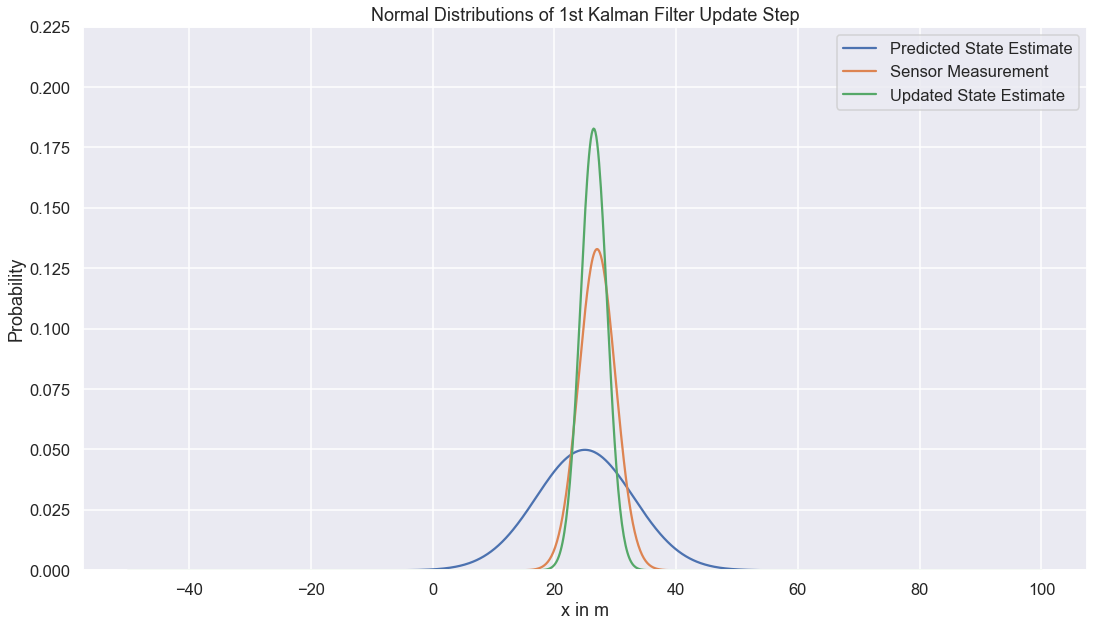

In [26]:
plt.figure(figsize=(18,10))
plt.plot(x, stats.norm.pdf(x, new_mean, new_var), label='Predicted State Estimate')
plt.plot(x, stats.norm.pdf(x, meanSensor, varSensor), label='Sensor Measurement')
plt.plot(x, stats.norm.pdf(x, mean, var), label='Updated State Estimate')
plt.ylim(0, 0.225);
plt.legend(loc='best');
plt.title('Normal Distributions of 1st Kalman Filter Update Step');
plt.ylabel('Probability');
plt.xlabel('x in m');

## Measurement update decreases uncertainty!

## The 1D Kalman Filter Cycle

In [27]:
positions = (10, 20, 30, 40, 50) + 2 * np.random.randn(5) # e.g. GNSS
distances = (10, 10, 10, 10, 10) + 2 * np.random.randn(5) # Motion model

In [28]:
print("Positions: ", positions, "\n")
print("Distances: ", distances)

Positions:  [12.45519019 16.92238003 31.32230887 39.89686925 51.14911279] 

Distances:  [ 5.72153262 11.83728145  9.51105132 11.72215878 13.08650721]


After correction:  mean= 10.62	var= 2.18
After correction:  mean= 18.55	var= 2.12
After correction:  mean= 30.36	var= 2.11
After correction:  mean= 40.54	var= 2.11
After correction:  mean= 51.89	var= 2.11

Adding odometry measurements: position estimate= 51.88
Last position measurement:    position estimate= 51.15



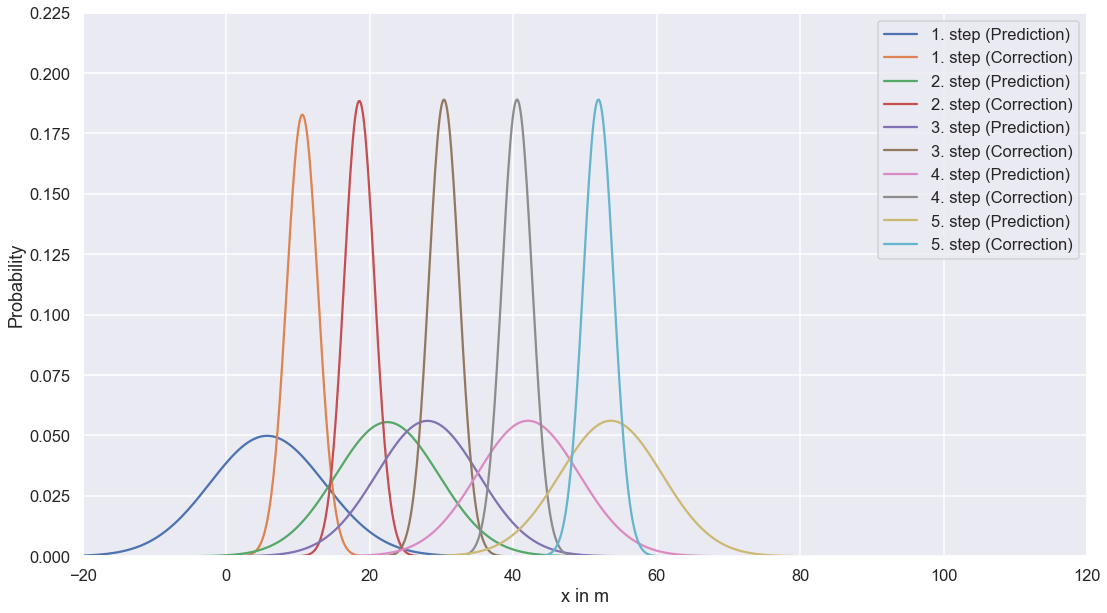

In [29]:
mean = mean0
var = var0

plt.figure(figsize=(18,10))

for m in range(len(positions)):
    
    # Predict
    var, mean = predict(var, mean, varMove, distances[m])
    #print('mean: %.2f\tvar:%.2f' % (mean, var))
    plt.plot(x, stats.norm.pdf(x, mean, var), label='%i. step (Prediction)' % (m+1))
    
    # Correct
    var, mean = update(var, mean, varSensor, positions[m])
    print('After correction:  mean= %.2f\tvar= %.2f' % (mean, var))
    plt.plot(x, stats.norm.pdf(x, mean, var), label='%i. step (Correction)' % (m+1))

plt.ylim(0, 0.225);
plt.xlim(-20, 120)
plt.ylabel('Probability');
plt.xlabel('x in m');
plt.legend(); 

print('')
print('Adding odometry measurements: position estimate= %.2f' % (sum(distances)))
print('Last position measurement:    position estimate= %.2f' % (positions[-1]))
print('')

![Kalman Cycle](resources/KF_cycle.png) 

# Conclusion

The sensors are represented as normal distributions with their parameters ($\mu$ and $\sigma^2$). 
The prediction increases the uncertainty about the state, the correction decreases the uncertainty.

* Prediction: Unertainty $\uparrow$
* Correction: Uncertainty $\downarrow$

If you have more than one state (here: position), than you have to use the multidimensional Kalman Filter, which is pretty much the same, but with matrices.


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Acknowledgement

https://github.com/balzer82/PyData-Berlin-2014-Kalman <br>
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python